# Test different interpolations

In [1]:
import numpy as np
import scipy.special as special
import scipy.integrate as integrate
import matplotlib.pyplot as plt
# fake beta function
def special_beta(alpha, beta): return special.gamma(alpha)*special.gamma(beta)/special.gamma(alpha+beta)

In [2]:
def get_toy_pdf_x(alpha, beta):
    """test fnc in x"""
    return lambda x,alpha=alpha,beta=beta: x**alpha * (1-x)**beta
def get_toy_pdf_N(alpha, beta):
    return lambda N: special_beta(N+alpha,beta+1)

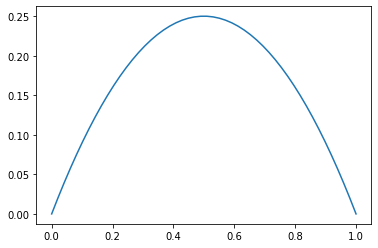

In [3]:
xs = np.linspace(0,1)
ys = get_toy_pdf_x(1,1)(xs)
plt.plot(xs,ys)
plt.show()

In [4]:
def get_linear_iterpolators_x(x,xgrid,j):
    """get j-th linear interpolator of grid"""
    l = len(xgrid)
    if l < 2 : raise "need at least 2 points"
    if 0 == j: return (xgrid[1]-x)/(xgrid[1]) if x <= xgrid[1] else 0.
    if l - 1 == j: return (x-xgrid[-2])/(xgrid[-1] - xgrid[-2]) if x >= xgrid[-2] else 0.
    if (xgrid[j]-x)*(x-xgrid[j-1]) > 0:
        return (x-xgrid[j-1])/(xgrid[j]-xgrid[j-1])
    if (xgrid[j]-x)*(x-xgrid[j+1]) >= 0:
        return (xgrid[j+1]-x)/(xgrid[j+1]-xgrid[j])
    return 0.

In [5]:
def get_Lagrange_iterpolators_x(x,xgrid,j):
    """get j-th Lagrange interpolator of grid in x"""
    l = len(xgrid)
    if l < 2 : raise "need at least 2 points"
    d = np.prod([1 if j == k else xgrid[j] - xgrid[k] for k in range(l)])
    n = np.prod([1 if j == k else x - xgrid[k] for k in range(l)])
    return n/d
def get_Lagrange_iterpolators_N(N,xgrid,j):
    """get j-th Lagrange interpolator of grid in N"""
    l = len(xgrid)
    if l < 2 : raise "need at least 2 points"
    d = np.prod([1 if j == k else xgrid[j] - xgrid[k] for k in range(l)])
    from numpy.polynomial import Polynomial as P
    nx = np.prod([P([1]) if j == k else P([- xgrid[k],1]) for k in range(l)])
    n = np.sum([nx.coef[k]/(N+k) for k in range(l)])
    return n/d

In [6]:
def get_Lagrange_iterpolators_log_x(x,xgrid,j):
    """get j-th Lagrange interpolator of log10(grid) in x"""
    l = len(xgrid)
    x = np.log(x)
    xgrid = np.log(np.array(xgrid))
    if l < 2 : raise "need at least 2 points"
    d = np.prod([1 if j == k else xgrid[j] - xgrid[k] for k in range(l)])
    n = np.prod([1 if j == k else x - xgrid[k] for k in range(l)])
    return n/d
def get_Lagrange_iterpolators_log_N(N,xgrid,j):
    """get j-th Lagrange interpolator of log10(grid) in N"""
    l = len(xgrid)
    xgrid = np.log(np.array(xgrid))
    if l < 2 : raise "need at least 2 points"
    d = np.prod([1 if j == k else xgrid[j] - xgrid[k] for k in range(l)])
    from numpy.polynomial import Polynomial as P
    nx = np.prod([P([1]) if j == k else P([- xgrid[k],1]) for k in range(l)])
    n = np.sum([nx.coef[k]*(np.math.factorial(k))/N*(-1./N)**k for k in range(l)])
    return n/d

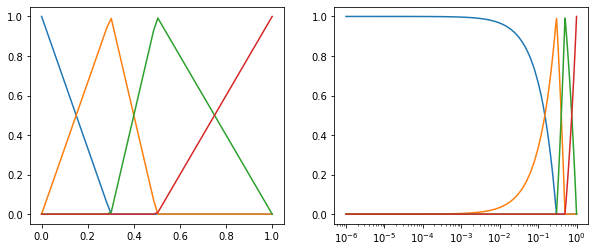

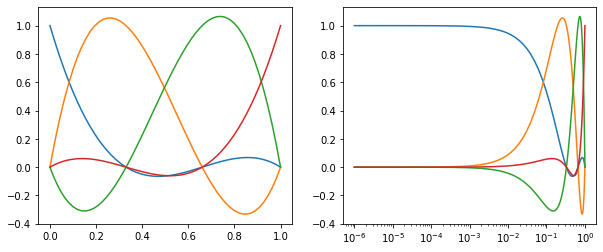

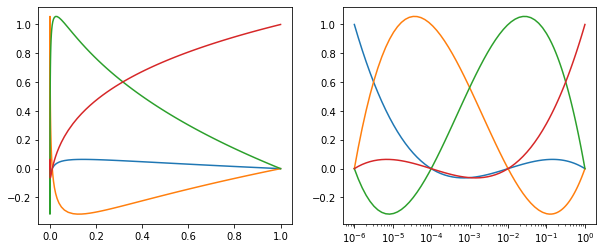

In [8]:
def plot_iterpolators_x(f,g,xmin=1e-6):
    """plot all linear interpolators of grid"""
    xs = np.append(np.logspace(np.log10(xmin),-1),np.linspace(0.1,1.))
    plt.figure(figsize=(10,4))
    plt.title("all interpolators p_j(x)")
    plt.subplot(1,2,1)
    for j in range(len(g)):
        ys = [f(x,g,j) for x in xs]
        plt.plot(xs,ys)
    plt.subplot(1,2,2)
    for j in range(len(g)):
        ys = [f(x,g,j) for x in xs]
        plt.semilogx(xs,ys)
    plt.show()

plot_iterpolators_x(get_linear_iterpolators_x,[0.,.3,.5,1.])
plot_iterpolators_x(get_Lagrange_iterpolators_x,[0.,.33,.66,1.])
plot_iterpolators_x(get_Lagrange_iterpolators_log_x,[1e-6,1e-4,1e-2,1.])

In [41]:
def plot_dist(x,y,yref):
    """compare to distributions both in linear and logarithmic x-space"""
    plt.figure(figsize=(15,5))
    plt.subplot(2,3,1)
    plt.title("small x")
    plt.semilogx(x,y,"o")
    plt.semilogx(x,yref,"x")
    plt.subplot(2,3,4)
    plt.loglog(x,np.abs((y - yref)/yref),"x")
    plt.subplot(2,3,2)
    plt.title("linear x")
    plt.plot(x,y,"o")
    plt.plot(x,yref,"x")
    plt.subplot(2,3,5)
    plt.semilogy(x,np.abs((y - yref)/yref),"x")
    oMx = 1 - x
    ax = plt.subplot(2,3,3)
    ax.set_xlim(1e-3,.1)
    plt.title("large x, i.e. small (1-x)")
    plt.loglog(oMx,y,"o")
    plt.loglog(oMx,yref,"x")
    ax = plt.subplot(2,3,6)
    ax.set_xlim(1e-3,.1)
    plt.loglog(oMx,np.abs((y - yref)/yref),"x")
    plt.xlabel("1-x")

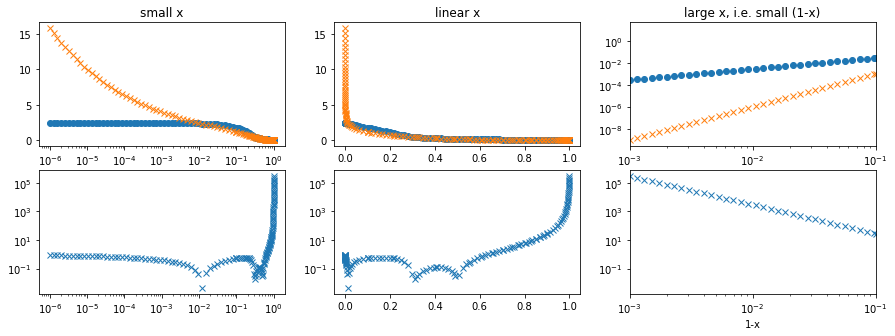

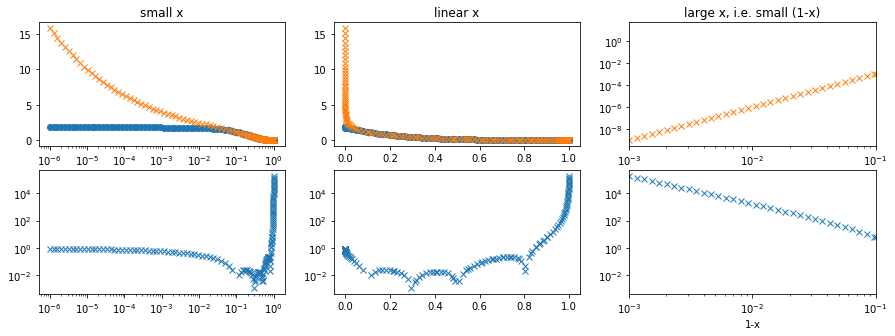

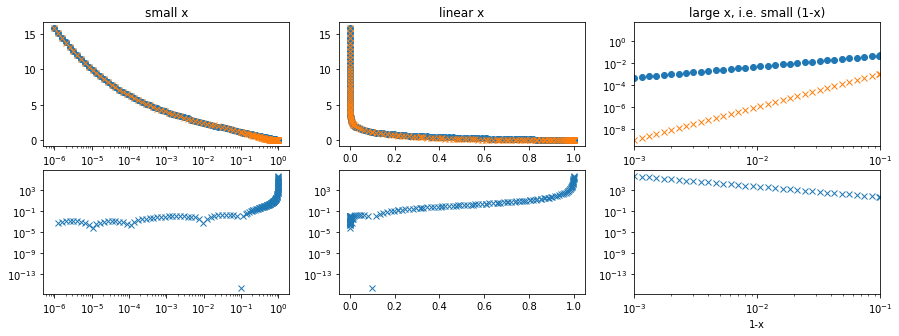

In [42]:
def test_iterpolation_x(f,p,g,xmin=1e-6):
    """plots interpolation vs real thing in x"""
    fs = [f(x) for x in g]
    fp = lambda y,g=g,fs=fs: np.sum([fs[j]*p(y,g,j) for j in range(len(g))])

    oMx = 1.0 - np.logspace(-3,np.log10(.9))
    xs = np.append(np.logspace(np.log10(xmin),-1),[np.linspace(0.1,.9),oMx])
    xs = np.sort(xs)
    yref = np.array([f(x) for x in xs])
    y = np.array([fp(x) for x in xs])

    plot_dist(xs,y,yref)

toy_alpha = -.2
toy_beta = 3.
test_iterpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), get_linear_iterpolators_x, [.01,.3,.5,1.])
test_iterpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), get_Lagrange_iterpolators_x, [.1,.3,.5,.8,1.])
test_iterpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), get_Lagrange_iterpolators_log_x, [1e-6,1e-5,1e-4,1e-2,1e-1,1.])

In [43]:
def Mellin_transform(f,N):
    """straight implementation of the Mellin transform"""
    r,re = integrate.quad(lambda x,f=f,N=N: np.real(x**(N-1)*f(x)),0,1)
    i,ie = integrate.quad(lambda x,f=f,N=N: np.imag(x**(N-1)*f(x)),0,1)
    return np.complex(r,i),np.complex(re,ie)

In [44]:
toy_alpha = 2.3
toy_beta = .5
for c in [np.complex(2,2),np.complex(2,-2),np.complex(-1,2)]:
    e = get_toy_pdf_N(toy_alpha,toy_beta)(c)
    i,ie = Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),c)
    print("exact = ",e,", int = ",i,", |rel_err| = ",np.abs((e-i)/e))

exact =  (0.06506938494905695-0.046801971951956206j) , int =  (0.0650693849441131-0.04680197194966553j) , |rel_err| =  6.797962151083868e-11
exact =  (0.06506938494905695+0.046801971951956206j) , int =  (0.0650693849441131+0.04680197194966553j) , |rel_err| =  6.797962151083868e-11
exact =  (0.041834527464115055-0.21549284638271926j) , int =  (0.041834527409332224-0.21549284630671234j) , |rel_err| =  4.268121107916933e-10


In [45]:
g = [0.,.5,1.]
for k in range(len(g)):
    for c in [np.complex(2,2),np.complex(2,-2),np.complex(-1,2)]:
        e = get_Lagrange_iterpolators_N(c,g,k)
        i,ie = Mellin_transform(lambda x: get_Lagrange_iterpolators_x(x,g,k),c)
        print("exact = ",e,", int = ",i,", |rel_err| = ",np.abs((e-i)/e))

exact =  (-0.04230769230769227+0.011538461538461553j) , int =  (-0.042307691866726164+0.011538461538452381j) , |rel_err| =  1.0055574301762228e-08
exact =  (-0.04230769230769227-0.011538461538461553j) , int =  (-0.042307691866726164-0.011538461538452381j) , |rel_err| =  1.0055574301762228e-08
exact =  (0.2+0.30000000000000004j) , int =  (0.19999999975547797+0.29999999959768586j) , |rel_err| =  1.3057497987283011e-09
exact =  (0.12307692307692308-0.2153846153846154j) , int =  (0.12307692307791729-0.2153846153792987j) , |rel_err| =  2.180376900395882e-11
exact =  (0.12307692307692308+0.2153846153846154j) , int =  (0.12307692307791729+0.2153846153792987j) , |rel_err| =  2.180376900395882e-11
exact =  (-0.8-0.3999999999999999j) , int =  (-0.8000000000000056-0.3999999999999926j) , |rel_err| =  1.0277811322930146e-14
exact =  (0.16923076923076924-0.046153846153846156j) , int =  (0.16923076924086644-0.04615384615517567j) , |rel_err| =  5.805975165046727e-11
exact =  (0.16923076923076924+0.046

In [46]:
g = [1e-4,1e-2,1.]
for k in range(len(g)):
    for c in [1,2,3,np.complex(2,2),np.complex(2,-2)]:
        e = get_Lagrange_iterpolators_log_N(c,g,k)
        i,ie = Mellin_transform(lambda x: get_Lagrange_iterpolators_log_x(x,g,k),c)
        print("exact = ",e,", int = ",i,", |rel_err| = ",np.abs((e-i)/e))

exact =  -0.06142069622290948 , int =  (-0.06142069622290948+0j) , |rel_err| =  0.0
exact =  -0.021249289587340306 , int =  (-0.021249289587340316+0j) , |rel_err| =  4.898206508542206e-16
exact =  -0.010317331006464274 , int =  (-0.010317331013046606+0j) , |rel_err| =  6.379878572895378e-10
exact =  (-0.0014735288829032342+0.012098173676573388j) , int =  (-0.001473528875837463+0.012098173701495102j) , |rel_err| =  2.12544212811159e-09
exact =  (-0.0014735288829032342-0.012098173676573388j) , int =  (-0.001473528875837463-0.012098173701495102j) , |rel_err| =  2.12544212811159e-09
exact =  0.3399886333974449 , int =  (0.3399886333974448+0j) , |rel_err| =  3.2654710056948044e-16
exact =  0.0967853894125871 , int =  (0.09678538941258709+0j) , |rel_err| =  1.4338721879450978e-16
exact =  0.044762133229775874 , int =  (0.04476213324233134+0j) , |rel_err| =  2.8049296821440686e-10
exact =  (0.0029470577658064685-0.05133975247210002j) , int =  (0.002947057549180242-0.0513397524036965j) , |rel_

In [47]:
def inverse_Mellin_transform(f,path,jac,x,cut=0.):
    """inverse Mellin transformation"""
    return integrate.quad(lambda u,f=f,path=path,jac=jac,x=x: np.real(np.complex(0.,-1./(2.*np.pi))*np.exp(-path(u)*np.log(x)) * f(path(u)) * jac(u)), cut, 1.-cut)

def get_path_line(max,c=1):
    """get straight line parallel to imaginary axis"""
    return (lambda t,max=max,c=c: np.complex(c,max*(2*t-1)), 
            lambda t,max=max: np.complex(0,max* 2     )
            )

def get_path_edge(max):
    """get edged path with angle 45°"""
    return (lambda t,max=max: 1. + (.5-t)*max*np.exp(np.complex(0,-np.pi*2./3.)) if t < .5 else 
                              1. + (t-.5)*max*np.exp(np.complex(0, np.pi*2./3.)),
            lambda t,max=max:            -max*np.exp(np.complex(0,-np.pi*2./3.)) if t < .5 else 
                                          max*np.exp(np.complex(0, np.pi*2./3.))
            )

def get_path_Talbot():
    """get Talbot path"""
    return (lambda t: np.complex(1 if .5 == t else np.pi*(2.*t-1.)/np.tan(np.pi*(2.*t-1.))                                           ,np.pi*(2.*t-1.)),
            lambda t: np.pi*2.*np.complex(0 if .5 == t else 1./np.tan(np.pi*(2.*t-1.)) - np.pi*(2.*t-1.)/(np.sin(np.pi*(2.*t-1.)))**2, 1.))


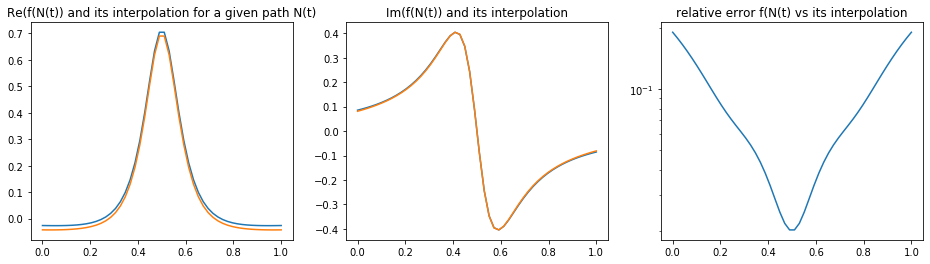

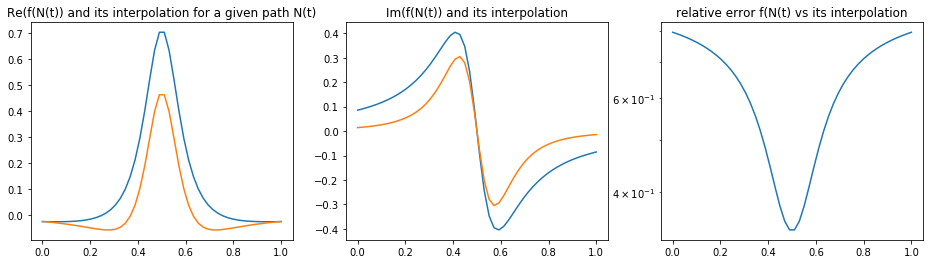

In [51]:
def test_iterpolation_N(fx,fN,pN,g,path,ts = np.linspace(0,1)):
    """plots interpolation to real thing in x"""
    fxs = [fx(x) for x in g]
    fNp = lambda N,g=g,fxs=fxs: np.sum([fxs[j]*pN(N,g,j) for j in range(len(g))])
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.title("Re(f(N(t)) and its interpolation for a given path N(t)")
    ys = [fN(path(t)) for t in ts]
    yps = [fNp(path(t)) for t in ts]
    plt.plot(ts,np.real(ys))
    plt.plot(ts,np.real(yps))
    plt.subplot(1,3,2)
    plt.title("Im(f(N(t)) and its interpolation")
    plt.plot(ts,np.imag(ys))
    plt.plot(ts,np.imag(yps))
    plt.subplot(1,3,3)
    plt.title("relative error f(N(t) vs its interpolation")
    plt.semilogy(ts,[np.abs((ys[j] - yps[j])/ys[j]) for j in range(len(xs))])
    plt.show()

toy_alpha = 0.0
toy_beta = .4
p,j = get_path_line(5)
test_iterpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    get_Lagrange_iterpolators_N,
                    np.linspace(0,1,num=5),
                    p
                    )
test_iterpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    get_Lagrange_iterpolators_log_N,
                    np.logspace(-6,0,num=6),
                    p
                    )

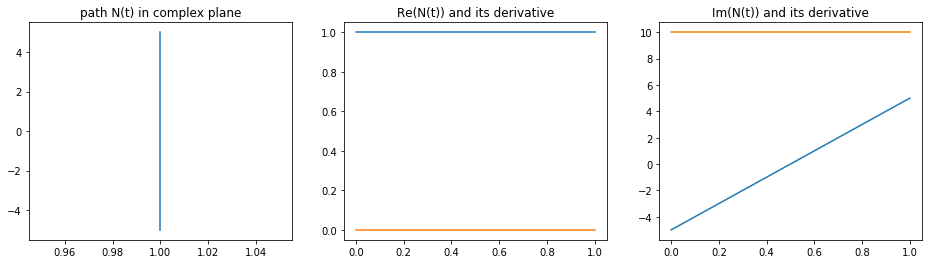

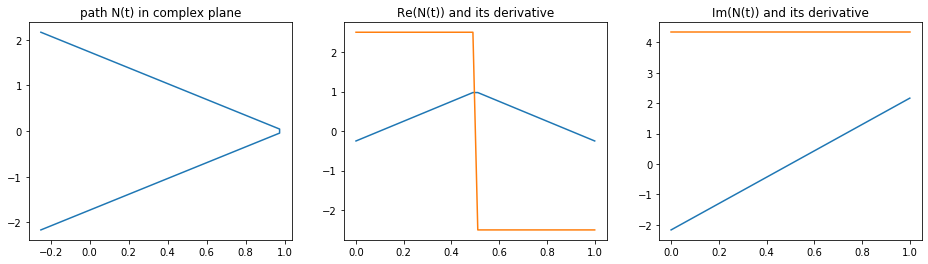

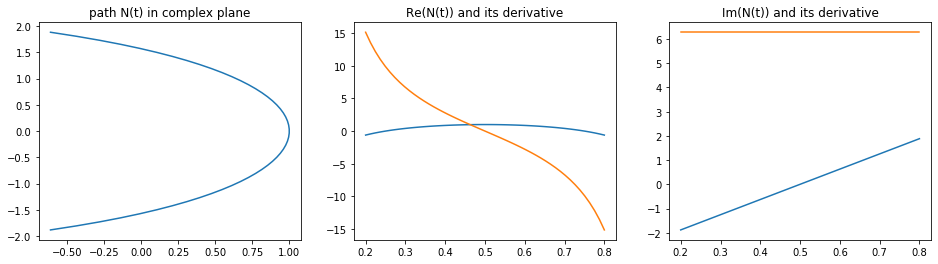

In [52]:
def plot_path(path,jac,plot_ts = np.linspace(0.,1)):
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.title("path N(t) in complex plane")
    ps = [path(t) for t in plot_ts]
    plt.plot(np.real(ps),np.imag(ps))
    plt.subplot(1,3,2)
    plt.title("Re(N(t)) and its derivative")
    pds = [jac(t) for t in plot_ts]
    plt.plot(plot_ts,np.real(ps))
    plt.plot(plot_ts,np.real(pds))
    plt.subplot(1,3,3)
    plt.title("Im(N(t)) and its derivative")
    plt.plot(plot_ts,np.imag(ps))
    plt.plot(plot_ts,np.imag(pds))
    plt.show()

p,j = get_path_line(5)
plot_path(p,j)
p,j = get_path_edge(5)
plot_path(p,j)
p,j = get_path_Talbot()
plot_path(p,j,np.linspace(.2,.8))

/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in cdouble_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  This is separate from the ipykernel package so we can avoid doing 

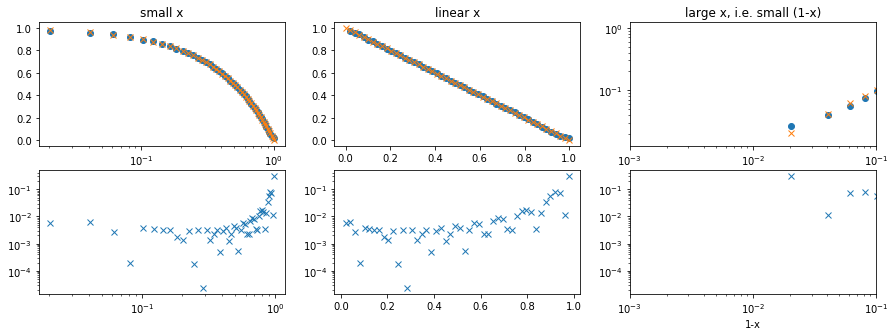

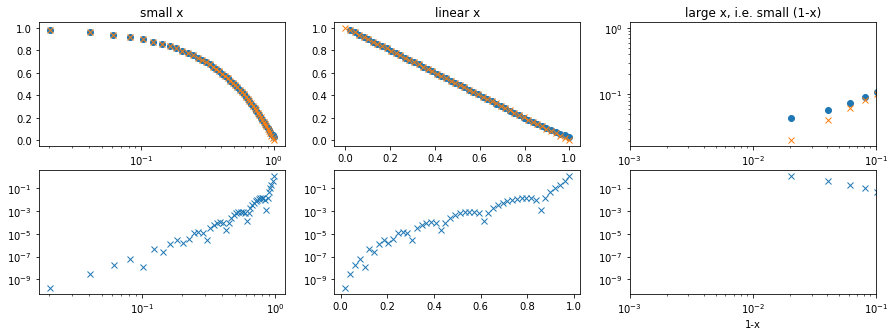

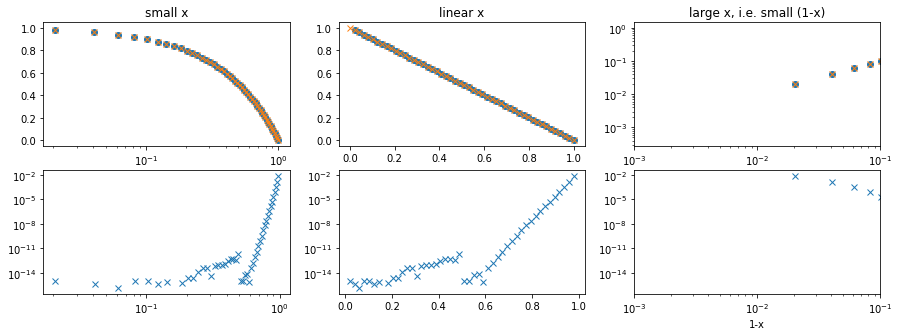

In [54]:
def test_inverse_Mellin_transform(fx,fN,path,jac,cut=0.):
    """plot Mellin integration path and compare numeric inversion to real thing"""
    xs = np.linspace(0.,1.)
    ys = [fx(x) for x in xs]
    yps = [inverse_Mellin_transform(fN,path,jac,x,cut) for x in xs]
    if isinstance(yps[0],tuple):
        yps = [yp[0] for yp in yps]

    plot_dist(xs,np.array(yps),np.array(ys))

toy_alpha = 0
toy_beta = 1
p,j = get_path_line(20)
test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j)
p,j = get_path_edge(20)
test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j)
p,j = get_path_Talbot()
test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j,1e-2)

/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in cdouble_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  This is separate from the ipykernel package so we can avoid doing 

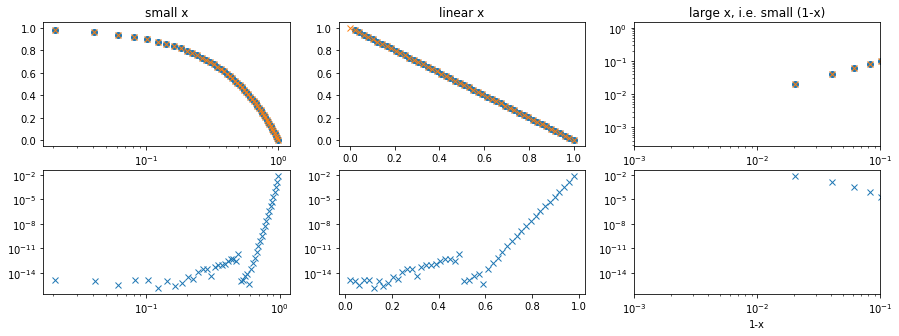

In [55]:
def test_inv_interpolation_x(fx,pN,g,path,jac,cut=0.):
    """compare interpolated numeric inversion to real thing"""
    fxs = [fx(x) for x in g]
    fNp = lambda N,pN=pN,g=g,fxs=fxs: np.sum([fxs[j]*pN(N,g,j) for j in range(len(g))])
    return test_inverse_Mellin_transform(fx,fNp,path,jac,cut)

p,j = get_path_Talbot()
test_inv_interpolation_x(get_toy_pdf_x(0.,1.),
                     get_Lagrange_iterpolators_N,
                     [0.,.5,1.],
                     p,j,1e-2
                     )

[0.01253604390908819, 0.1090842587659851, 0.2830581304412209, 0.49999999999999994, 0.716941869558779, 0.890915741234015, 0.9874639560909118]
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in cdouble_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the reque

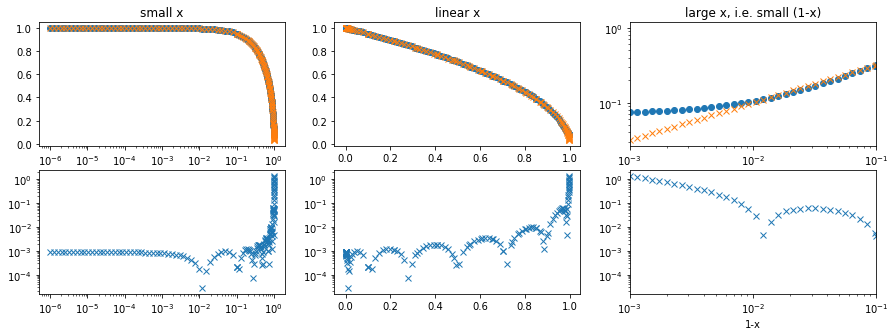

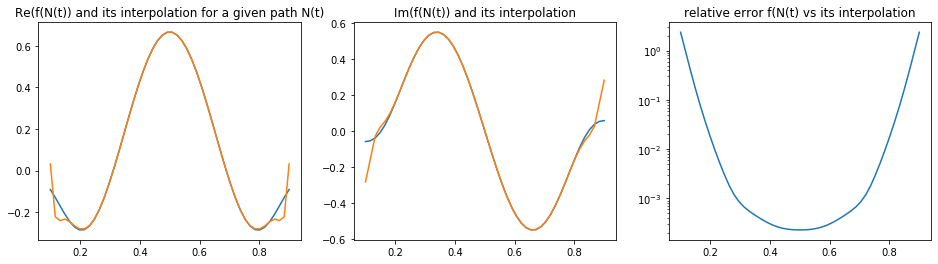

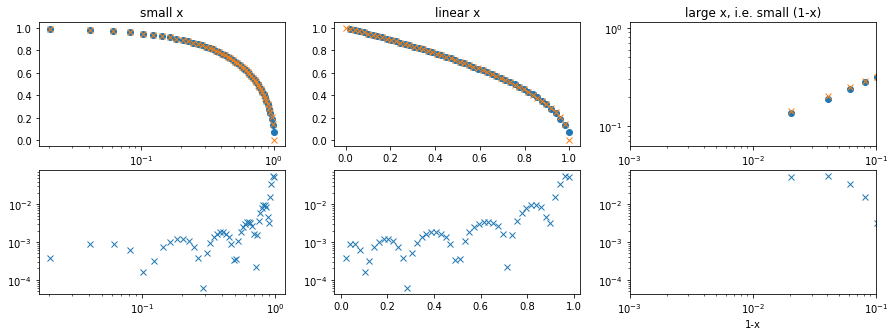

In [56]:
toy_alpha = 0.
toy_beta = .5
#g = np.linspace(0.,1.,num=7)
n_points = 7
g = [.5 - .5*np.cos((2.*j+1)/(2.*n_points)*np.pi) for j in range(n_points)]
print(g)
test_iterpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_Lagrange_iterpolators_x,
                    g)
p,j = get_path_Talbot()
#plot_path(p,j,np.linspace(.2,.8))
test_iterpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    get_Lagrange_iterpolators_N,
                    g,
                    p,
                    np.linspace(.1,.9))
test_inv_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                         get_Lagrange_iterpolators_N,
                         g,
                         p,j,
                         1e-2
                        )

In [58]:
g = [.5 - .5*np.cos((2.*j+1)/(2.*n_points)*np.pi) for j in range(n_points)]
gg = [10.**(-6. + 6.*e) for e in g]
print(gg)
gg = [np.exp(np.log(1e-6) + np.log(1e6)*e) for e in g]
print(gg)

[1.189094207336904e-06, 4.513417958554193e-06, 4.992853033786162e-05, 0.000999999999999999, 0.020028628786649537, 0.2215615768765043, 0.8409762606106714]
[1.1890942073369042e-06, 4.51341795855419e-06, 4.9928530337861565e-05, 0.0009999999999999994, 0.020028628786649533, 0.22156157687650455, 0.8409762606106718]


[1.189094207336904e-06, 4.513417958554193e-06, 4.992853033786162e-05, 0.000999999999999999, 0.020028628786649537, 0.2215615768765043, 0.8409762606106714]
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in cdouble_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in exp
  This is separate 

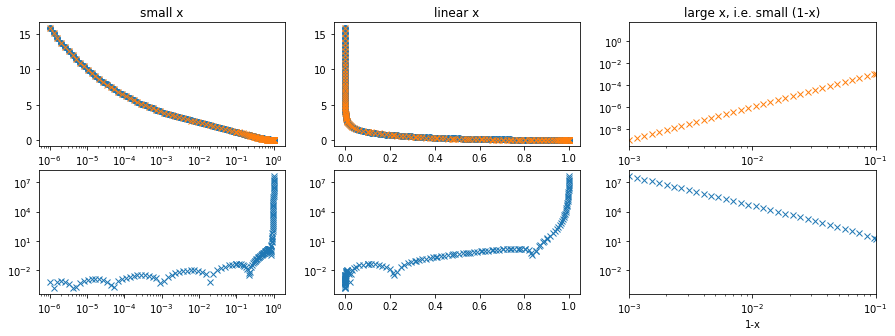

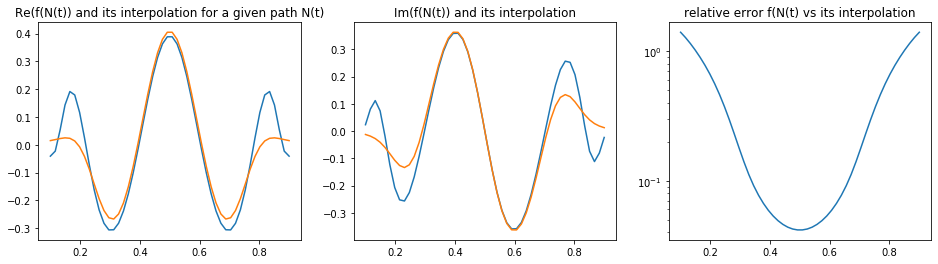

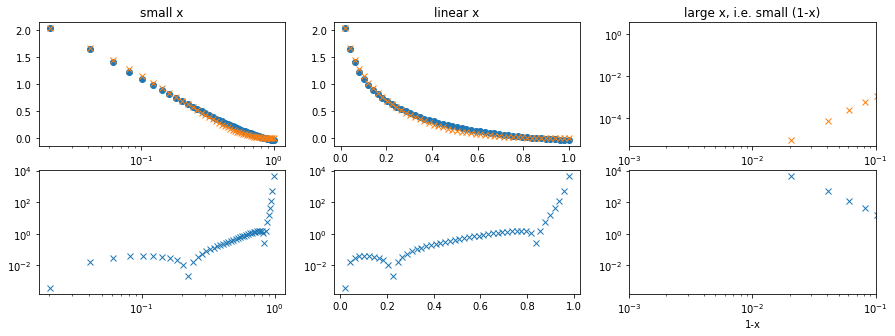

In [57]:
toy_alpha = -0.2
toy_beta = 3.
n_points = 7
#g = np.linspace(0.,1.,num=n_points)
#g = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1.0]
g = [.5 - .5*np.cos((2.*j+1)/(2.*n_points)*np.pi) for j in range(n_points)]
g = [10.**(-6. + 6.*e) for e in g]
print(g)
test_iterpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_Lagrange_iterpolators_log_x,
                    g)
#p,j = get_path_line(10)
p,j = get_path_Talbot()
#plot_path(p,j,np.linspace(.2,.8))
test_iterpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    get_Lagrange_iterpolators_log_N,
                    g,
                    p,
                    np.linspace(.1,.9))
test_inv_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                         get_Lagrange_iterpolators_log_N,
                         g,
                         p,j,
                         1e-2
                        )